# Maximum likelihood fit for the model

Now that the model is defined, we find the maximum likelihood fit and report the results

## Imports

In [1]:
import numpy as np
from scipy.optimize import minimize, root
from matplotlib import pyplot as plt

In [2]:
from numpy import cos, cosh, sin, sinh, sqrt, abs, pi, log

## Problem size

Number of students, number of questions

In [3]:
S = 100
Q = 20

## Generating data

Number of latent factors for data generation. The data generated seems to have less structure if $l$ is high.

In [4]:
l = 2

We work with binary data which could represent a multiple choice question being answered correctly or incorrectly. The method can be used to use nonbinary data as well.

In [5]:
hidden_s = np.random.normal(10, 1, (S, l))
hidden_q = np.random.normal(10, 1, (l, Q))
p = hidden_s @ hidden_q
p -= np.min(p)
p /= np.max(p) # Matrix of probabilities
A = np.random.binomial(1, p, (S, Q))

### Filtering out extreme values

There is no information in rows or columns which are all zero or one with this ML method.They are not interesting to consider, we remove them for this demonstration. They could easily be reintegrated later.

In [6]:
is_constant = lambda axis: np.logical_or(np.all(A == 1, axis=axis), np.all(A == 0, axis=axis))
delete_constant = lambda axis: np.delete(A, np.where(is_constant(1 - axis)), axis=axis)
A = delete_constant(0)
A = delete_constant(1)

In [7]:
S, Q = A.shape
S, Q

(100, 20)

## Utility

In [8]:
pack = lambda s, q: np.concatenate((np.reshape(s, S), np.reshape(q, Q)))
unpack = lambda x: (np.reshape(x[:S], S), np.reshape(x[S:], Q))

In [9]:
bounds = [(0, 1)] * (S + Q)

## Running the minimization procedure

Demonstration to show how the method can be called.

In [10]:
initial_guess = pack(np.mean(A, axis=1), np.mean(A, axis=0))

In [11]:
from functools import partial
from mle import neg_log_likelihood, d_neg_log_likelihood

In [12]:
from pde import p as pde_p, dpds as pde_dpds, dpdq as pde_dpdq

In [13]:
from multiprocessing import Pool

In [14]:
%%time
result = minimize(
    partial(neg_log_likelihood, p=pde_p, A=A, S=S),
    initial_guess,
    jac=partial(d_neg_log_likelihood, p=pde_p, dpds=pde_dpds, dpdq=pde_dpdq, A=A, S=S),
    bounds=bounds,
)

CPU times: user 770 ms, sys: 0 ns, total: 770 ms
Wall time: 771 ms


Thanks to the implementation of the jacobian, the solver is very fast. The problem is however not convex; as such, we solve the same problem multiple times with a different starting value and use the best solution.

In [15]:
def find_best(_):
    return minimize(
    partial(neg_log_likelihood, p=pde_p, A=A, S=S),
    np.random.rand(S + Q),
    jac=partial(d_neg_log_likelihood, p=pde_p, dpds=pde_dpds, dpdq=pde_dpdq, A=A, S=S),
    bounds=bounds,
)

with Pool(7) as pool:
    results = pool.map(find_best, range(100))

The method is not entirely stable; it doesn't always terminate successfully.

In [16]:
np.mean([x.success for x in results])

0.54

The best solution is the one with the highest likelihood.

In [17]:
result = min(filter(lambda x: x.success, results), key=lambda x: x.fun)

In [18]:
s, q = unpack(result.x)

In [19]:
s_order, q_order = np.argsort(s), np.argsort(q)

## Results

Below is a plot of the simulated data sorted by student ability and question easyness, as well as the fitted values. At the bottom is the fitted value for the student abilities.

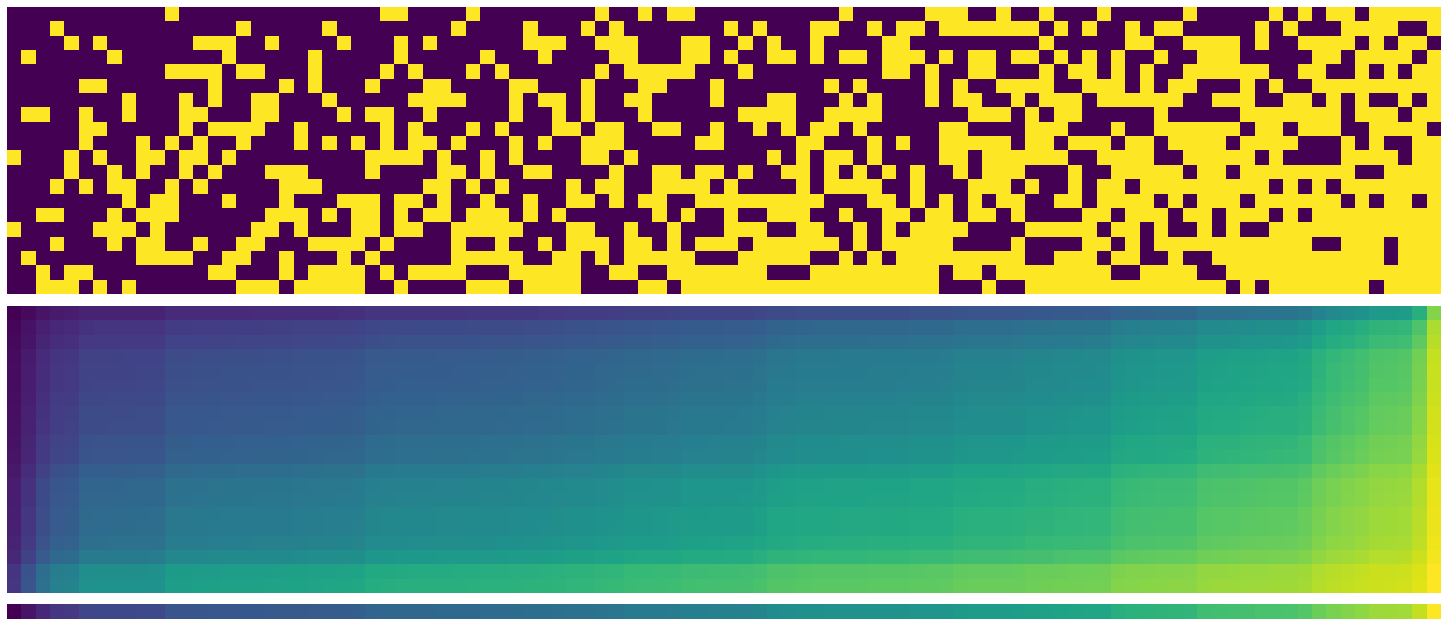

In [20]:
width = 20
fig = plt.figure(constrained_layout=True, figsize=(width, width / S * (Q + 1 + Q + 1 + 1)))
gs = fig.add_gridspec(ncols=1, nrows=3, height_ratios=[Q, Q, 1], wspace=0, hspace=0)
gs.update(hspace=.01)
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_axis_off()
ax1.imshow(np.transpose(A[s_order, :][:, q_order]))
ax2 = fig.add_subplot(gs[1, 0])
ax2.set_axis_off()
ax2.imshow(np.transpose(pde_p(*np.meshgrid(s, q, sparse=True, indexing='ij'))[s_order, :][:, q_order]))
ax3 = fig.add_subplot(gs[2, 0])
ax3.set_axis_off()
ax3.imshow(np.reshape(s[s_order], (1, S)))

For small problems, the $s_i$ values tend to be ordered by the number of questions answered correctly.

In [21]:
np.all(np.diff(np.sum(A[s_order], axis=1)) >= 0)

True

Note that different ability values around found within the groups of students answering the same number of questions correctly.

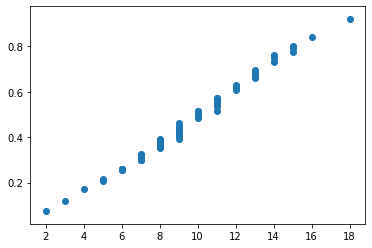

In [22]:
%matplotlib inline
plt.scatter(np.sum(A[s_order, :], axis=1), s[s_order])

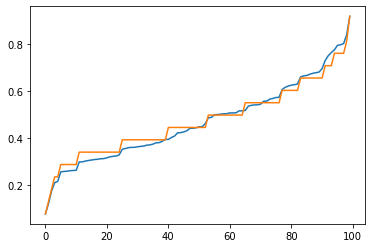

In [23]:
plt.plot(s[s_order])
naive = np.sum(A[s_order, :], axis=1)
plt.plot((naive - naive.min()) / (naive.max() - naive.min()) * (s.max() - s.min()) + s.min())

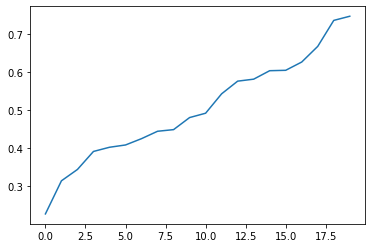

In [24]:
plt.plot(q[q_order])

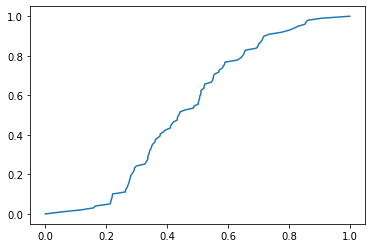

In [25]:
normalized = (s - s.min()) / (s.max() - s.min())
plt.plot(normalized[s_order], np.linspace(0, 1, len(normalized)))

# Converting the ability values to a grade

The code below is not at the heart of this project, but demonstrates a possible way to map the ability values on a grade. 

We may want to push the grades assigned in a certain desired distribution. We then need to consider how flexible we should choose this map; if it is too flexible, we lose the relative distances between ability scores also locally.

In [26]:
def scale(params, x): # Utility function: scale to [params[0], params[1]] linearly
    # to [0, 1]
    normalized = (x - x.min()) / (x.max() - x.min())
    return normalized[:, np.newaxis, np.newaxis] * (params[1] - params[0])[np.newaxis] + params[0]

Grading system for Swiss universities:

In [27]:
# ETH
minimum_grade = 1
maximum_grade = 6
minimum_passing_grade = 4

In [28]:
eth_to_standard = lambda x: (x - minimum_grade) / (maximum_grade - minimum_grade) # Utility function

Chosen settings:

In [29]:
fraction_passing = .8 # rho
mean_grade = eth_to_standard(4.5)
mean_grade # mu

0.7

In [30]:
passing_threshold = eth_to_standard(minimum_passing_grade)
passing_threshold # tau

0.6

We choose a beta distribution for the grades and solve for the distribution's parameters.

In [31]:
from scipy.stats import beta

\begin{align}
\mu &= \frac{\alpha}{\alpha + \beta} & q(\rho) = \tau
\end{align}

In [32]:
beta_f = lambda alpha: alpha * (1 - mean_grade) / mean_grade

In [33]:
def cdf_of(alpha):
    if alpha > 1:
        return beta.cdf(passing_threshold, alpha, beta_f(alpha)) - (1 - fraction_passing)
    else:
        return 1000

In [34]:
root_result = root(
    cdf_of,
    100,
)

We find the following values:

In [35]:
alpha = root_result.x
alpha, beta_f(alpha)

(array([9.80829559]), array([4.20355525]))

Sanity check:

In [36]:
beta.cdf(passing_threshold, alpha, beta_f(alpha)), beta.mean(alpha, beta_f(alpha))

(array([0.2]), array([0.7]))

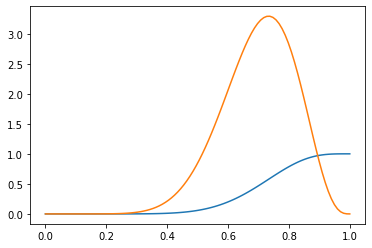

In [37]:
xs = np.linspace(0, 1, 100)
plt.plot(xs, beta.cdf(xs, alpha, beta_f(alpha)))
plt.plot(xs, beta.pdf(xs, alpha, beta_f(alpha)))

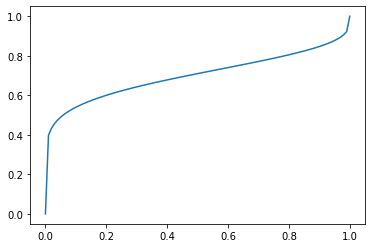

In [38]:
plt.plot(xs, beta.ppf(xs, alpha, beta_f(alpha)))

In [39]:
passing_threshold, beta.cdf(passing_threshold, alpha, beta_f(alpha)), beta.cdf(mean_grade, alpha, beta_f(alpha))

(0.6, array([0.2]), array([0.46869342]))

We will interpret the ability values $s_i$ as quantiles of the chosen distribution above. To achieve the desired passing fraction and mean grade, we allow linear scaling of those quantiles as well. These choices are somewhat arbitrary.

In [40]:
def fit_error(params, x):
    transformed = beta.ppf(scale(params, x), alpha, beta_f(alpha))
    quantile_error = abs(fraction_passing - np.mean(transformed >= passing_threshold, axis=0))
    mean_error = abs(mean_grade - np.mean(transformed, axis=0))
    return quantile_error + mean_error # Equally weighted L1 penalty, again, somewhat arbitrary

In [41]:
def a(_):
    return minimize(
        partial(fit_error, x=s),
        np.random.rand(2),
        bounds=[(0, 1)] * 2,
    )
with Pool(7) as pool:
    l = pool.map(a, list(range(1000)))

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/

This numerical process doesn't always terminate successfully either.

In [42]:
np.mean([x.success for x in l])

0.861

In [43]:
correct = list(filter(lambda x: x.x[0] < x.x[1], filter(lambda x: x.success, l)))
len(correct) / len(l)

0.382

(array([ 21.,   6.,  14.,   0.,  14.,   7.,  21.,  14., 264.,  21.]),
 array([0.11938458, 0.12838955, 0.13739452, 0.14639949, 0.15540446,
        0.16440943, 0.1734144 , 0.18241937, 0.19142434, 0.20042931,
        0.20943428]),
 <a list of 10 Patch objects>)

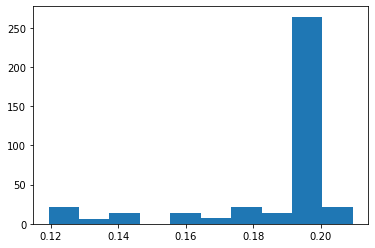

In [44]:
plt.hist([r.fun[0, 0] for r in correct])

We will use the best result from running the process multiple times, as we did above.

In [45]:
result = min(correct, key=lambda r: r.fun)
result

      fun: array([[0.11938458]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.2333179 , -0.16005177])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 3
   status: 0
  success: True
        x: array([0.0238138 , 0.82168335])

In [46]:
scaled = scale(result.x, s)[:, 0, 0]
scaled.min(), scaled.max()

(0.02381379908473609, 0.8216833518900943)

We now have a new distribution of what we will interpret as quantiles.

(array([ 1.,  1.,  2.,  7.,  9., 13., 10., 10., 13., 11.,  6.,  7.,  2.,
         3.,  4.,  0.,  1.,  0.,  0.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <a list of 20 Patch objects>)

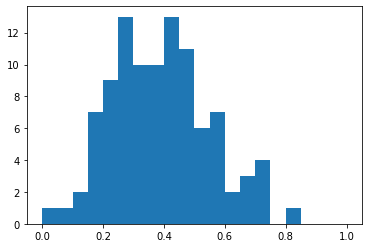

In [47]:
plt.hist(scaled, range=(0, 1), bins=20)

In [48]:
result.x

array([0.0238138 , 0.82168335])

We convert them to grades.

In [49]:
grades = beta.ppf(scaled, alpha, beta_f(alpha)) * (maximum_grade - minimum_grade) + minimum_grade

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,
         0.,  1.,  2.,  6.,  6., 13., 13., 10., 18.,  7., 12.,  3.,  5.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
        2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5,
        3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8,
        4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. ]),
 <a list of 50 Patch objects>)

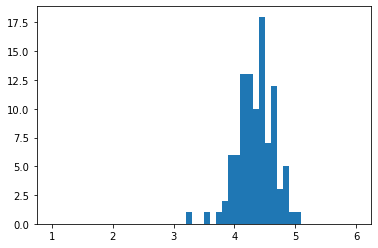

In [50]:
plt.hist(grades, range=(1, 6), bins=50)

In [51]:
np.mean(grades), np.mean(grades > minimum_passing_grade)

(4.35307709733714, 0.89)

In [52]:
grades.min(), grades.max()

(3.216968522495855, 5.06518148820583)

We notice how the grades we assign are somewhat close to the beta distribution we desired.